
## FoodGAN


#### By Jacob DeMuth

## Libraries

In [1]:
import torch
import sklearn
import random
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import imageio

import time

from torchvision import datasets
from torchvision import transforms

from torch.utils.data import TensorDataset, DataLoader

from torch.autograd import Variable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from mlxtend.plotting import heatmap

from sklearn.model_selection import train_test_split

from numpy import genfromtxt

from PIL import Image

## Device Info

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

## GPU Stuff

In [6]:
torch_device = torch.device("cpu")

if torch.cuda.is_available(): 
    torch_device = torch.device("cuda")

In [7]:
torch_device

device(type='cuda')


## Parameters


In [8]:
## diff learning rates supported by various sources
d_learning_rate    = 0.0004
g_learning_rate    = 0.0002
## Batch size supported by this paper
## https://arxiv.org/abs/1809.11096
batch_size       = 2048
N_Epochs         = 11000



## Data Path


In [9]:
train_data_path = "C:/Users/Jacob DeMuth/Documents/fast_food/Fast Food Classification V2/Train"
test_data_path = "C:/Users/Jacob DeMuth/Documents/fast_food/Fast Food Classification V2/Test"

## Train data

In [10]:
dataset_train = []
labels_train  = []
targets_train = []

In [11]:
for folder in os.listdir( train_data_path ):
    for image in os.listdir( os.path.join(train_data_path, folder) ):
        if folder not in labels_train:
            labels_train.append( folder )
        targets_train.append(  labels_train.index(folder)  )
        img_arr = imageio.imread(  os.path.join(train_data_path, folder, image), pilmode="RGB"  )
        
        img_pil = Image.fromarray(img_arr)
        img_pil = img_pil.resize((28, 28), Image.Resampling.LANCZOS)
        
        img = torch.from_numpy(np.array(img_pil)).permute( 2, 0, 1 ).float()
        
        img /= 255
        dataset_train.append(img)

C:\Users\Jacob DeMuth\AppData\Local\Temp\ipykernel_13484\1353408582.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread(  os.path.join(train_data_path, folder, image), pilmode="RGB"  )
C:\Users\Jacob DeMuth\anaconda3\envs\py38_ITS530\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## View Image(s) info

In [12]:
len(labels_train)

10

In [13]:
len( targets_train )

15000

In [14]:
dataset_train[3].shape

torch.Size([3, 28, 28])

## Train Data Setup

In [15]:
data_train    = torch.stack( dataset_train )
targets_train = torch.Tensor(  targets_train  ).type(   torch.LongTensor   )

In [16]:
data_train.shape

torch.Size([15000, 3, 28, 28])

In [17]:
targets_train.shape

torch.Size([15000])

In [18]:
data_train[4].shape

torch.Size([3, 28, 28])

In [19]:
targets_train[1500:1600]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

## View Image

In [20]:
img_tr = data_train[1001]
img_tr

tensor([[[0.7255, 0.6980, 0.7882,  ..., 0.7804, 0.7804, 0.7725],
         [0.6980, 0.6078, 0.6078,  ..., 0.7843, 0.7804, 0.7765],
         [0.7176, 0.8118, 0.5765,  ..., 0.7725, 0.7804, 0.7804],
         ...,
         [0.7569, 0.6392, 0.8627,  ..., 0.2353, 0.1843, 0.0392],
         [0.7255, 0.6706, 0.5373,  ..., 0.2902, 0.0471, 0.2118],
         [0.6471, 0.5373, 0.4039,  ..., 0.0706, 0.2157, 0.7490]],

        [[0.4863, 0.2902, 0.6118,  ..., 0.8941, 0.8941, 0.8902],
         [0.4510, 0.2824, 0.3882,  ..., 0.8980, 0.8941, 0.8941],
         [0.4510, 0.6196, 0.3412,  ..., 0.8941, 0.8980, 0.8941],
         ...,
         [0.5373, 0.3647, 0.5882,  ..., 0.1686, 0.1373, 0.0902],
         [0.4980, 0.4039, 0.2235,  ..., 0.2353, 0.1137, 0.2431],
         [0.4353, 0.3020, 0.1922,  ..., 0.1216, 0.2353, 0.6471]],

        [[0.4039, 0.1020, 0.3490,  ..., 0.9255, 0.9255, 0.9216],
         [0.2431, 0.0941, 0.2039,  ..., 0.9216, 0.9255, 0.9255],
         [0.1569, 0.2471, 0.1490,  ..., 0.9333, 0.9216, 0.

In [21]:
transform = T.ToPILImage()

In [22]:
img = transform(  img_tr  )

In [23]:
img

## Test Data

In [24]:
dataset_test = []
labels_test = []
targets_test = []

In [25]:
for folder in os.listdir( test_data_path ):
    for image in os.listdir( os.path.join(test_data_path, folder) ):
        if folder not in labels_test:
            labels_test.append( folder )
        targets_test.append(  labels_test.index(folder)  )
        img_arr = imageio.imread(  os.path.join(test_data_path, folder, image), pilmode="RGB"  )
        
        img_pil = Image.fromarray(img_arr)
        img_pil = img_pil.resize((28, 28), Image.Resampling.LANCZOS)
        
        img = torch.from_numpy(np.array(img_pil)).permute( 2, 0, 1 ).float()
        
        img /= 255
        dataset_test.append(img)

C:\Users\Jacob DeMuth\AppData\Local\Temp\ipykernel_13484\730514307.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_arr = imageio.imread(  os.path.join(test_data_path, folder, image), pilmode="RGB"  )


In [26]:
data_test = torch.stack(dataset_test)
targets_test = torch.tensor(targets_test, dtype=torch.long)

In [27]:
data_test.shape

torch.Size([5000, 3, 28, 28])

In [28]:
targets_test.shape

torch.Size([5000])

## Train and Test Datasetup

In [29]:
X_train = data_train  
y_train = targets_train

In [30]:
X_test = data_test  
y_test = targets_test 

## Change to float 32

In [31]:
X_train = X_train.numpy()
X_test  = X_test.numpy()

In [32]:
X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )

In [33]:
X_train = torch.from_numpy(X_train )
X_test = torch.from_numpy( X_test  )

## Normalize

In [34]:
img_norm_mean = (0.5, 0.5, 0.5)

In [35]:
img_norm_std = (0.5, 0.5, 0.5)

In [36]:

other_normalization = transforms.Compose([
                            transforms.Normalize( img_norm_mean, img_norm_std )
])

In [37]:
X_train = other_normalization( X_train )  

X_test  = other_normalization( X_test ) 

## Print Shapes

In [38]:
X_train.shape[0]

15000

In [39]:
y_train[300].item()
type(y_train[300].item())

int

In [40]:
y_train[300].item()

0

In [41]:
X_train[78]

tensor([[[ 0.1137,  0.2627, -0.0902,  ..., -0.7098, -0.7255, -0.7255],
         [-0.0745,  0.0510, -0.0431,  ...,  0.0275,  0.6078,  0.1137],
         [-0.1843, -0.0902, -0.3412,  ..., -0.3725,  0.4431, -0.4510],
         ...,
         [-0.0588,  0.0275,  0.0980,  ..., -0.5843,  0.4196,  0.2392],
         [-0.2000, -0.1765, -0.1373,  ..., -0.0431,  0.3725,  0.2392],
         [-0.2235, -0.1843, -0.1686,  ...,  0.3804,  0.2706,  0.2784]],

        [[-0.4667, -0.3333, -0.5137,  ..., -0.7176, -0.7098, -0.7098],
         [-0.6157, -0.4980, -0.5137,  ..., -0.0039,  0.5922,  0.0824],
         [-0.6235, -0.5216, -0.7255,  ..., -0.4275,  0.4353, -0.4745],
         ...,
         [-0.0667, -0.0118,  0.0275,  ..., -0.5451,  0.0588, -0.7020],
         [-0.2314, -0.2235, -0.2157,  ..., -0.0588, -0.2941, -0.7176],
         [-0.2471, -0.2235, -0.2314,  ...,  0.0980, -0.6549, -0.6549]],

        [[-0.8980, -0.8824, -0.8039,  ..., -0.6627, -0.6627, -0.6784],
         [-0.9843, -0.9137, -0.7412,  ..., -0

In [42]:
X_train.shape

torch.Size([15000, 3, 28, 28])

In [43]:
train_list = [  ( X_train[i],  y_train[i].item() )  for i in range( X_train.shape[0]   )  ]

In [44]:
test_list = [  ( X_test[i],  y_test[i].item() )  for i in range( X_test.shape[0]   )  ]


## Create Data Loaders


In [45]:
train_dl  = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, drop_last=True)

test_dl   = torch.utils.data.DataLoader(test_list,  batch_size=batch_size, shuffle=False, drop_last=True)


## Utility Functions


In [46]:
def plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked):
    
    the_epochs = [i for i in range(len(list_losses_real))]  

    plt.plot(the_epochs, list_losses_real,    label = "real") 
    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.plot(the_epochs, list_losses_tricked, label = "tricked")
    plt.legend() 
    plt.show()


In [47]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [48]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()


In [49]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 )
    return rand_vec


In [50]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) )
    return rand_vec

In [51]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, 10 ) )
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec



## NN Architectures


In [52]:
## References: https://www.reddit.com/r/MachineLearning/comments/i085a8/d_best_gan_tricks/
##             https://www.mathworks.com/help/deeplearning/ug/train-conditional-generative-adversarial-network.html

In [53]:
class Generator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100+10, 256)
        self.norm1   = nn.BatchNorm1d(256)
        self.act1    = nn.LeakyReLU(0.02)

        self.linear2 = nn.Linear(256, 512)
        self.norm2   = nn.BatchNorm1d(512)
        self.act2    = nn.LeakyReLU(0.02)

        self.linear3 = nn.Linear(512, 1024)
        self.norm3   = nn.BatchNorm1d(1024)
        self.act3    = nn.LeakyReLU(0.02)

        self.linear4 = nn.Linear(1024, 2048)
        self.norm4   = nn.BatchNorm1d(2048)
        self.act4    = nn.LeakyReLU(0.02)

        self.linear5 = nn.Linear(2048, 2352)
        self.norm5   = nn.BatchNorm1d(2352)
        self.act5    = nn.Tanh()
        

    def forward(self, rand_input, label_tensor ):
        
        #print(rand_input.shape)
        #print(label_tensor.shape)

        inputs = torch.cat( ( rand_input , label_tensor) , dim=1)

        x      = self.linear1( inputs )
        x      = self.norm1(x)
        x      = self.act1(x)
        
        x      = self.linear2(x)
        x      = self.norm2(x)
        x      = self.act2(x)

        x      = self.linear3(x)
        x      = self.norm3(x)
        x      = self.act3(x)

        x      = self.linear4(x)
        x      = self.norm4(x)
        x      = self.act4(x)
        
        x      = self.linear5(x)
        x      = self.norm5(x)
        y_pred = self.act5(x)
        
        return y_pred


In [54]:

class Discriminator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(2352+10, 1080)
        self.act1    = nn.LeakyReLU(0.02)
        self.dropout = nn.Dropout(0.5)
        
        self.linear2 = nn.Linear(1080, 512)
        self.act2    = nn.LeakyReLU(0.02)
        self.dropout = nn.Dropout(0.75)

        self.linear3 = nn.Linear(512, 128)
        self.act3    = nn.LeakyReLU(0.02)
        self.dropout = nn.Dropout(0.75)

        self.linear4 = nn.Linear(128, 1)
        self.act4   = nn.Sigmoid()
        

    def forward(self, x, label_tensor):
        
        inputs = torch.cat( (x, label_tensor) , dim=1)
        
        x      = self.linear1( inputs )
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        x      = self.act3(x)
        x      = self.dropout(x)
        x      = self.linear4(x)
        y_pred = self.act4(x)
        
        return y_pred
        


## Training Function


In [55]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []
    

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:              ## xb = [batch, 3, 28, 28]
            
            xb = torch.squeeze(xb, dim=3)
            xb = xb.reshape((2048, 2352))

            yb = F.one_hot(yb, num_classes=10)
            ## input()
       
            #################################################
            
            ## G_model.eval()     ## No G training
            
            rand_vector = random_batch_one_hot_rc(batch_size, 10)
            
            gen_img = G_model( random_G_batch_vector_input(),  rand_vector ).detach()
            
            
            ## Train D with real data
            D_real_y_pred = D_model(  xb, yb )
            D_real_loss   = D_loss_fn( D_real_y_pred, torch.ones((batch_size, 1)) )
            D_opt.zero_grad()
            D_real_loss.backward()
            D_opt.step()
            
            ## Train D with fake data
            D_fake_y_pred = D_model(  gen_img,  rand_vector  )
            D_fake_loss   = D_loss_fn( D_fake_y_pred, torch.zeros((batch_size, 1)))
            D_opt.zero_grad()
            D_fake_loss.backward()
            D_opt.step()
            
            ## G_model.train()    ## yes G training
            
            #################################################
            
            ## D_model.eval()     ## No D training
            
            
            rand_vector = random_batch_one_hot_rc(batch_size, 10)
            
            gen_img = G_model( random_G_batch_vector_input(), rand_vector )
            
            ## Train G with D_loss (need to trick D)
            D_tricked_y_pred = D_model(  gen_img, rand_vector  )
            D_tricked_loss   = D_loss_fn( D_tricked_y_pred, torch.ones((batch_size, 1)) )
            G_opt.zero_grad()
            D_tricked_loss.backward()
            G_opt.step()
            
            ## D_model.train()    ## yes D training
                        
       
            
        if epoch % 1 == 0:
            print("******************************")
            print(epoch, "D_real_loss=", D_real_loss)
            print(epoch, "D_fake_loss=", D_fake_loss)
            print(epoch, "D_tricked_loss=", D_tricked_loss)
            list_losses_real.append(        D_real_loss.detach().numpy()  )
            list_losses_fake.append(        D_fake_loss.detach().numpy()  )
            list_losses_tricked.append(  D_tricked_loss.detach().numpy()  )


## Call the core functions


In [56]:
start_time = time.perf_counter()
G_model     = Generator_Net()

D_model     = Discriminator_Net()

D_loss_fn   = nn.BCELoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=g_learning_rate )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=d_learning_rate )

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )
end_time = time.perf_counter()
print(f"Total Training Time: {end_time - start_time:0.4f} seconds")

******************************
0 D_real_loss= tensor(0.1487, grad_fn=<BinaryCrossEntropyBackward0>)
0 D_fake_loss= tensor(0.7782, grad_fn=<BinaryCrossEntropyBackward0>)
0 D_tricked_loss= tensor(0.6565, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
1 D_real_loss= tensor(0.3755, grad_fn=<BinaryCrossEntropyBackward0>)
1 D_fake_loss= tensor(0.4916, grad_fn=<BinaryCrossEntropyBackward0>)
1 D_tricked_loss= tensor(1.3841, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
2 D_real_loss= tensor(0.2617, grad_fn=<BinaryCrossEntropyBackward0>)
2 D_fake_loss= tensor(0.5299, grad_fn=<BinaryCrossEntropyBackward0>)
2 D_tricked_loss= tensor(2.0690, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
3 D_real_loss= tensor(0.5891, grad_fn=<BinaryCrossEntropyBackward0>)
3 D_fake_loss= tensor(0.2194, grad_fn=<BinaryCrossEntropyBackward0>)
3 D_tricked_loss= tensor(4.0099, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
4 D_r

#### Total Time: 11 hrs 9 min 59 sec
#### Time per epoch: ~4 seconds a epoch

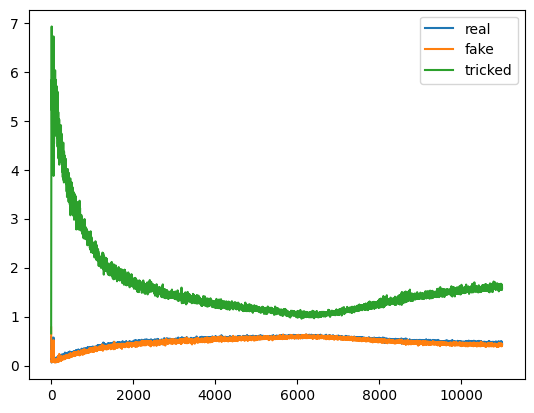

In [57]:
plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked)


## Test generating after training



## Print Images


In [58]:
label_index = {"Baked Potato" : 0, "Burger" : 1, "Crispy Chicken" : 2, "Donut" : 3, "Fries" : 4, "Hot Dog" : 5, "Pizza" : 6, "Sandwich" : 7, "Taco" : 8, "Taquito" : 9}

In [59]:
label = "Baked Potato"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


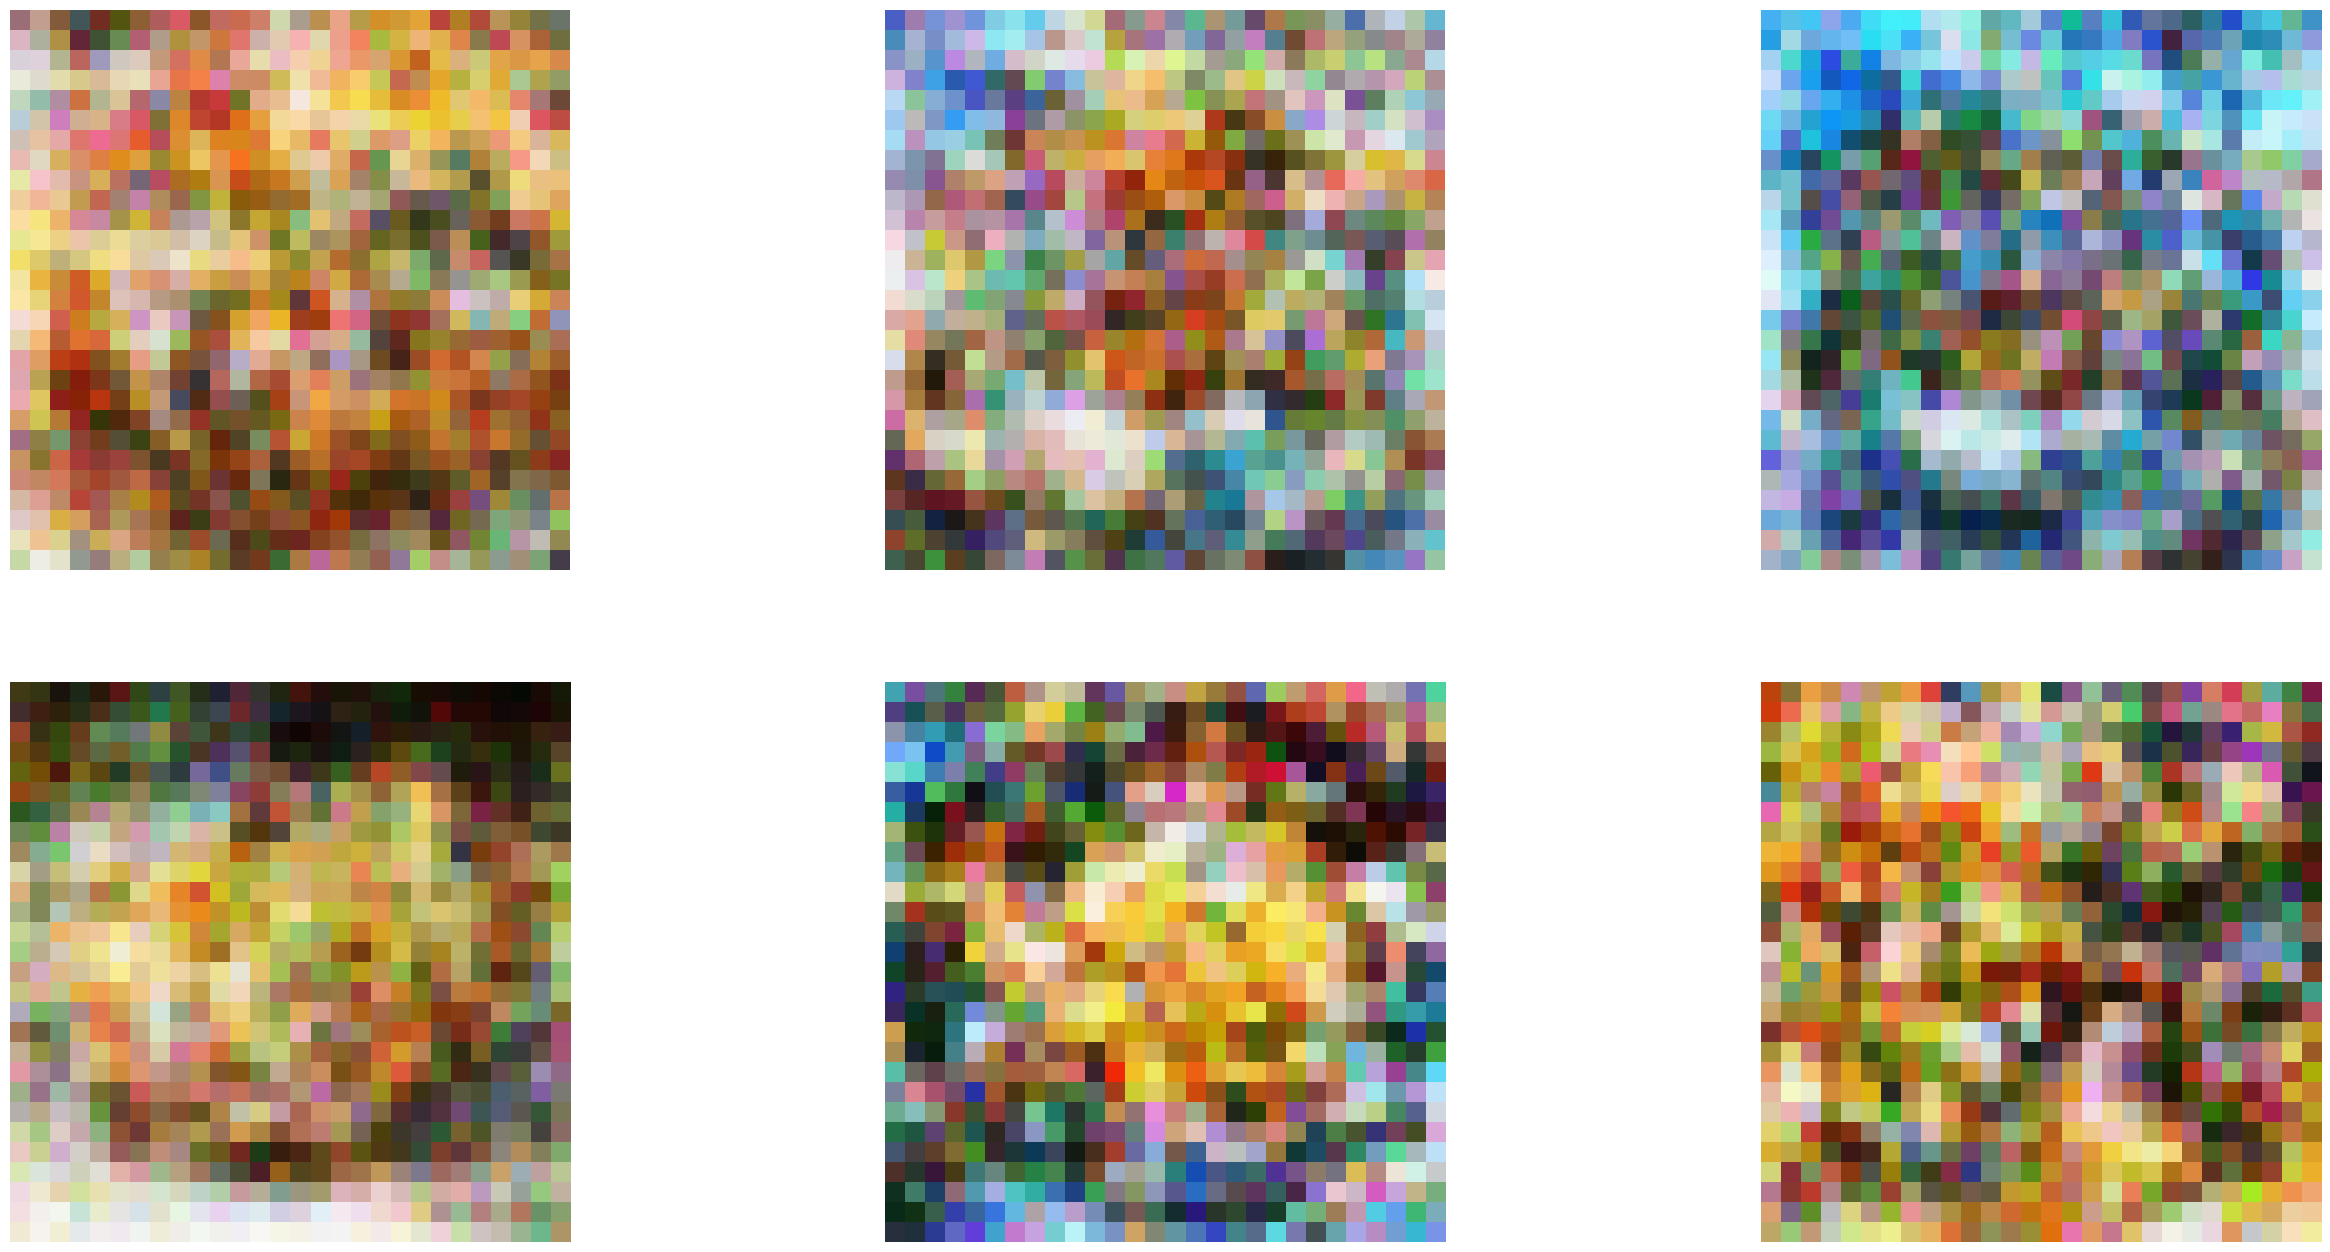

In [60]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()
      


In [61]:
label = "Burger"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


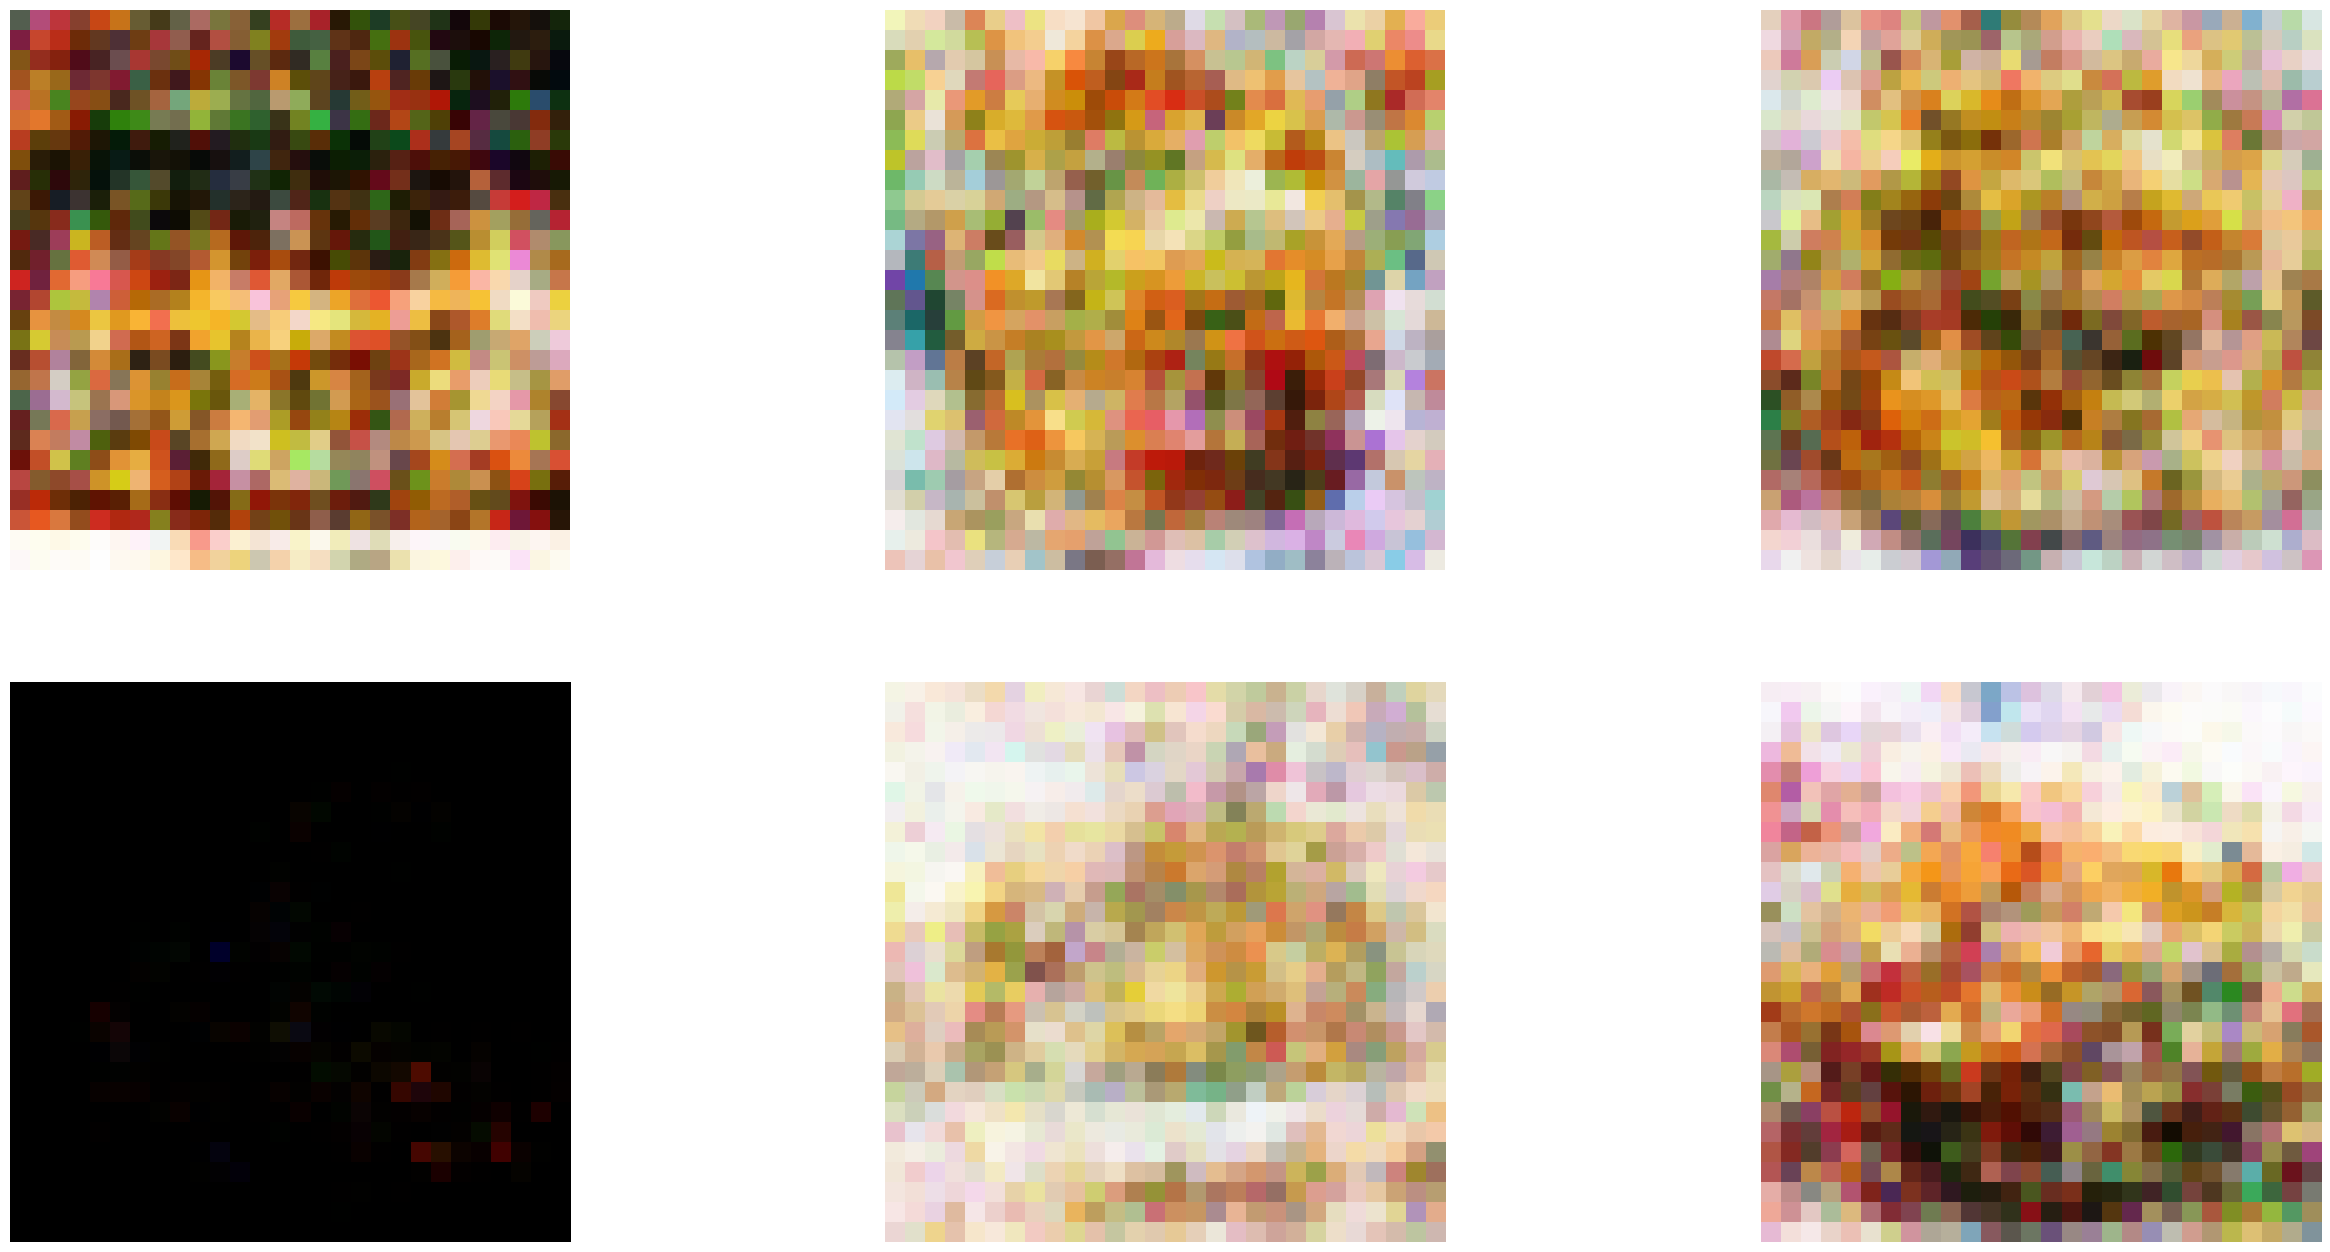

In [62]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [63]:
label = "Crispy Chicken"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


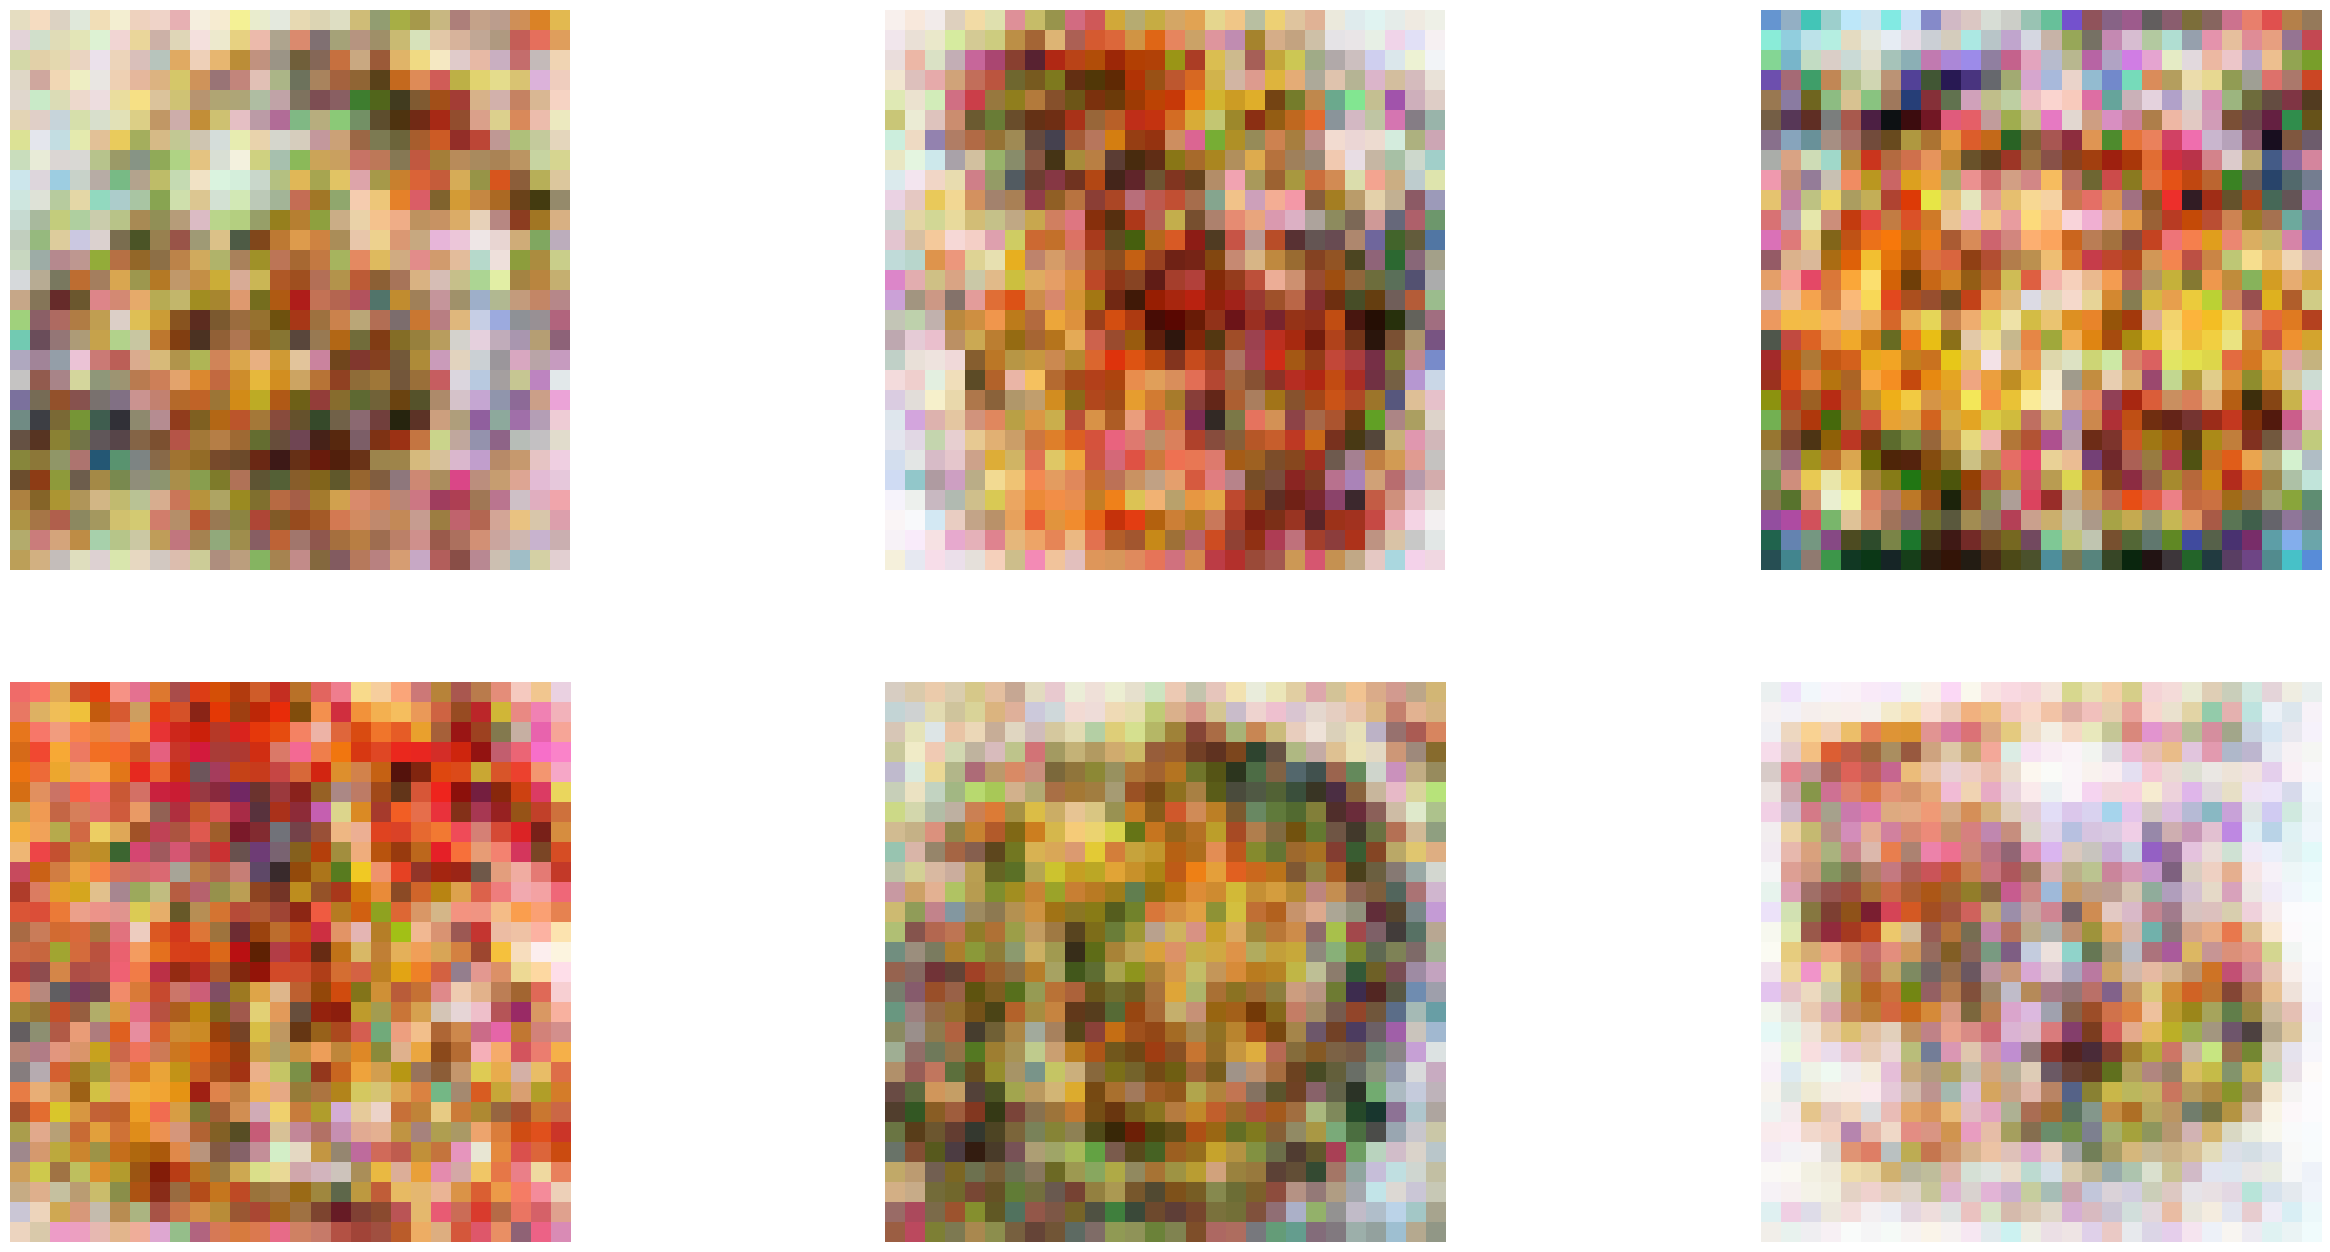

In [64]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [65]:
label = "Donut"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


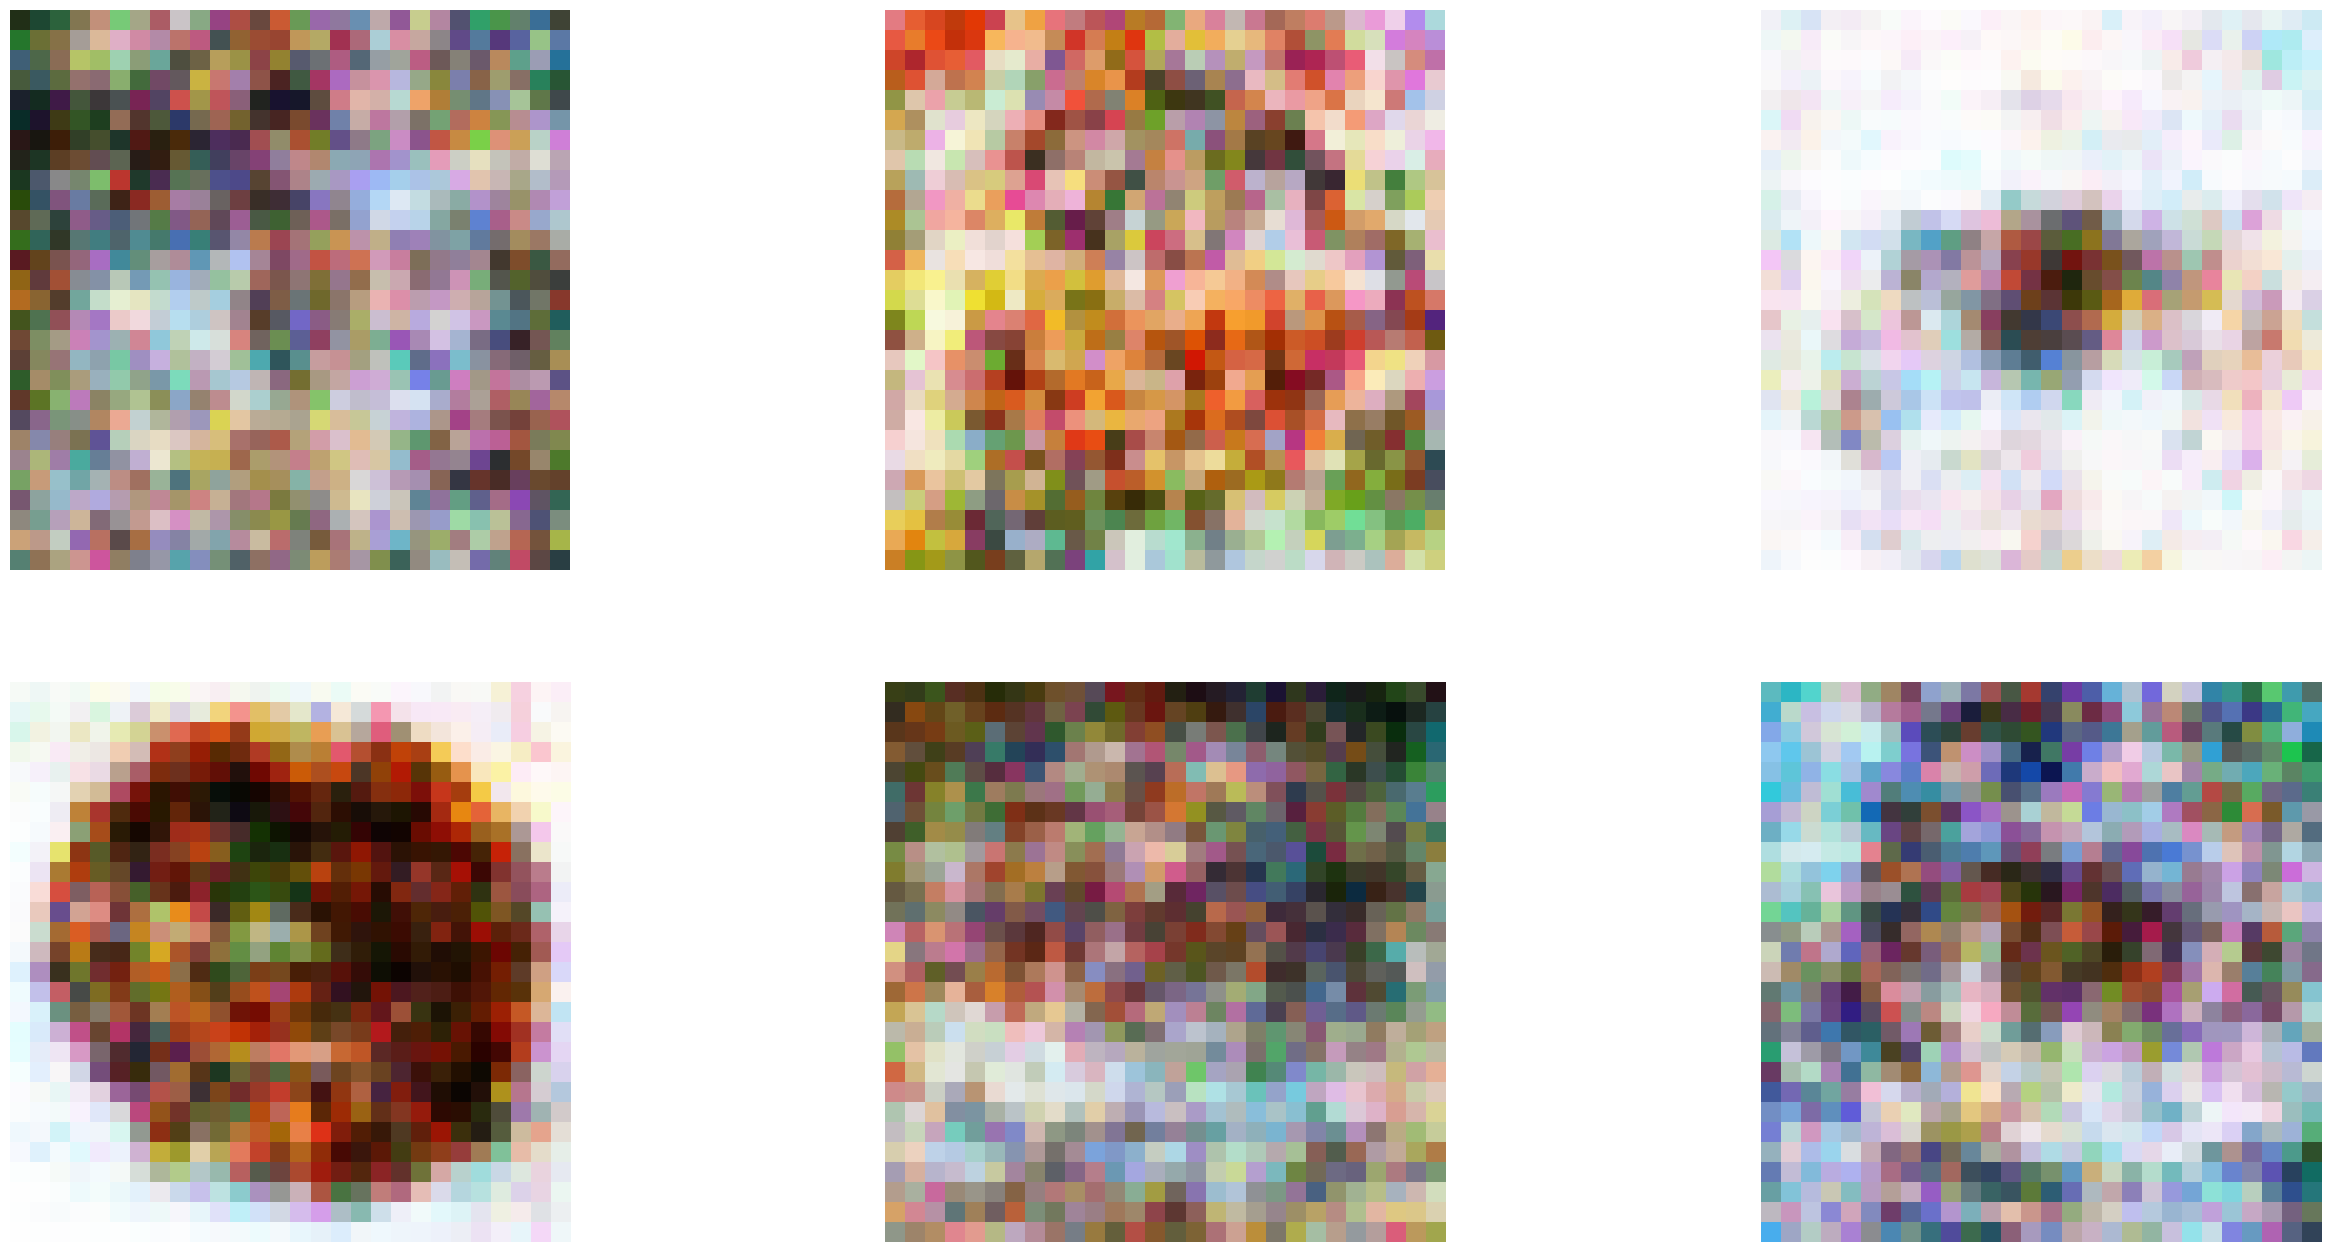

In [66]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [67]:
label = "Fries"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


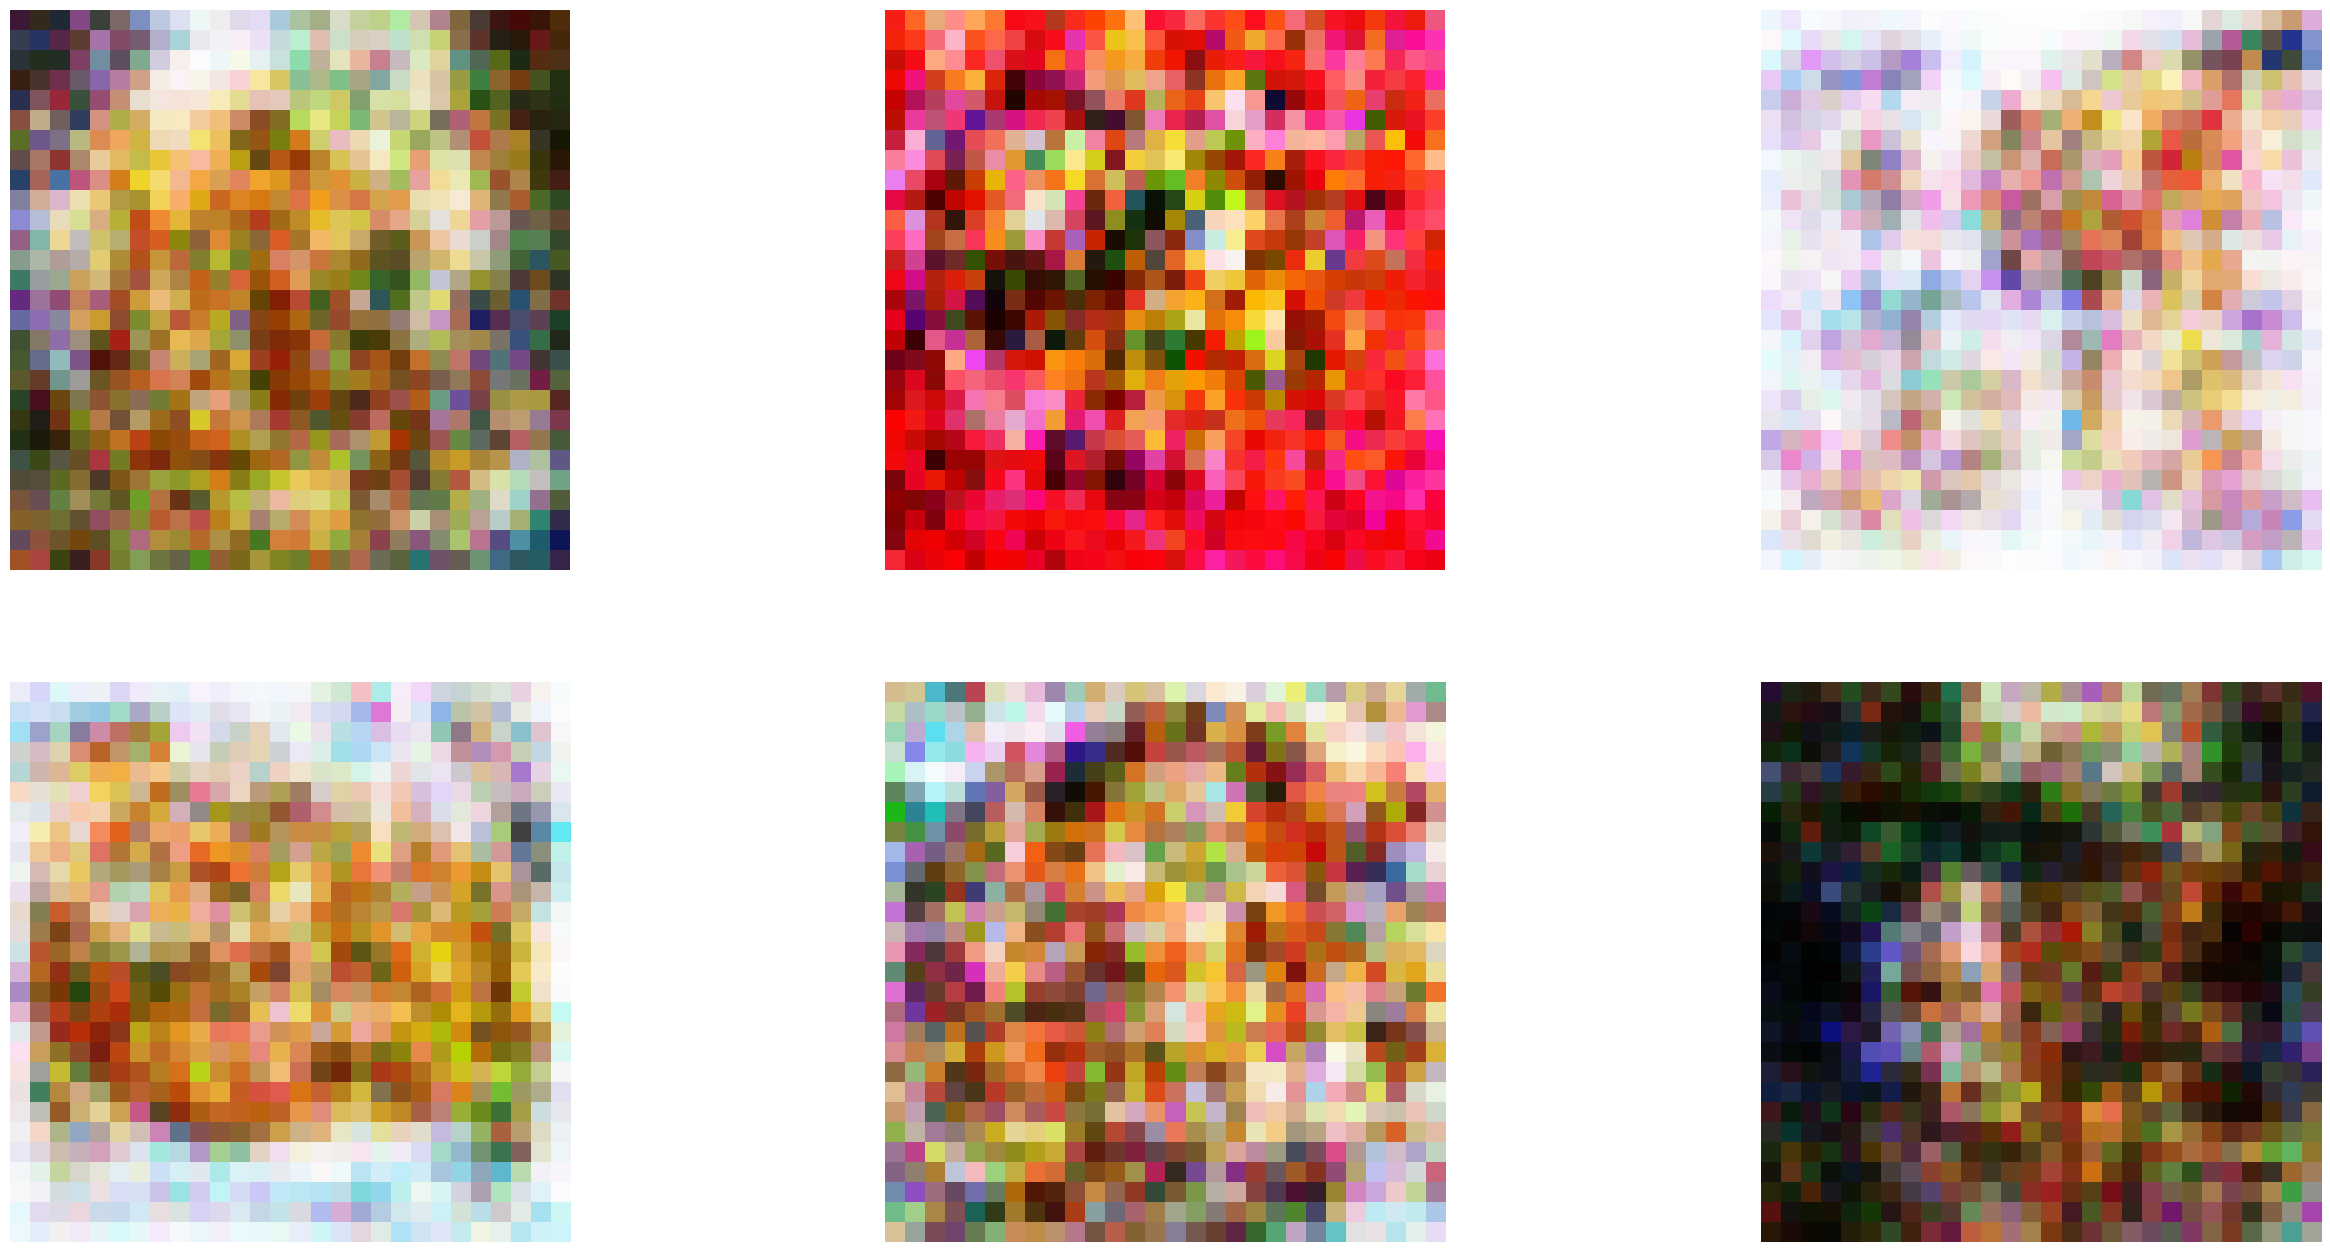

In [68]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [69]:
label = "Hot Dog"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


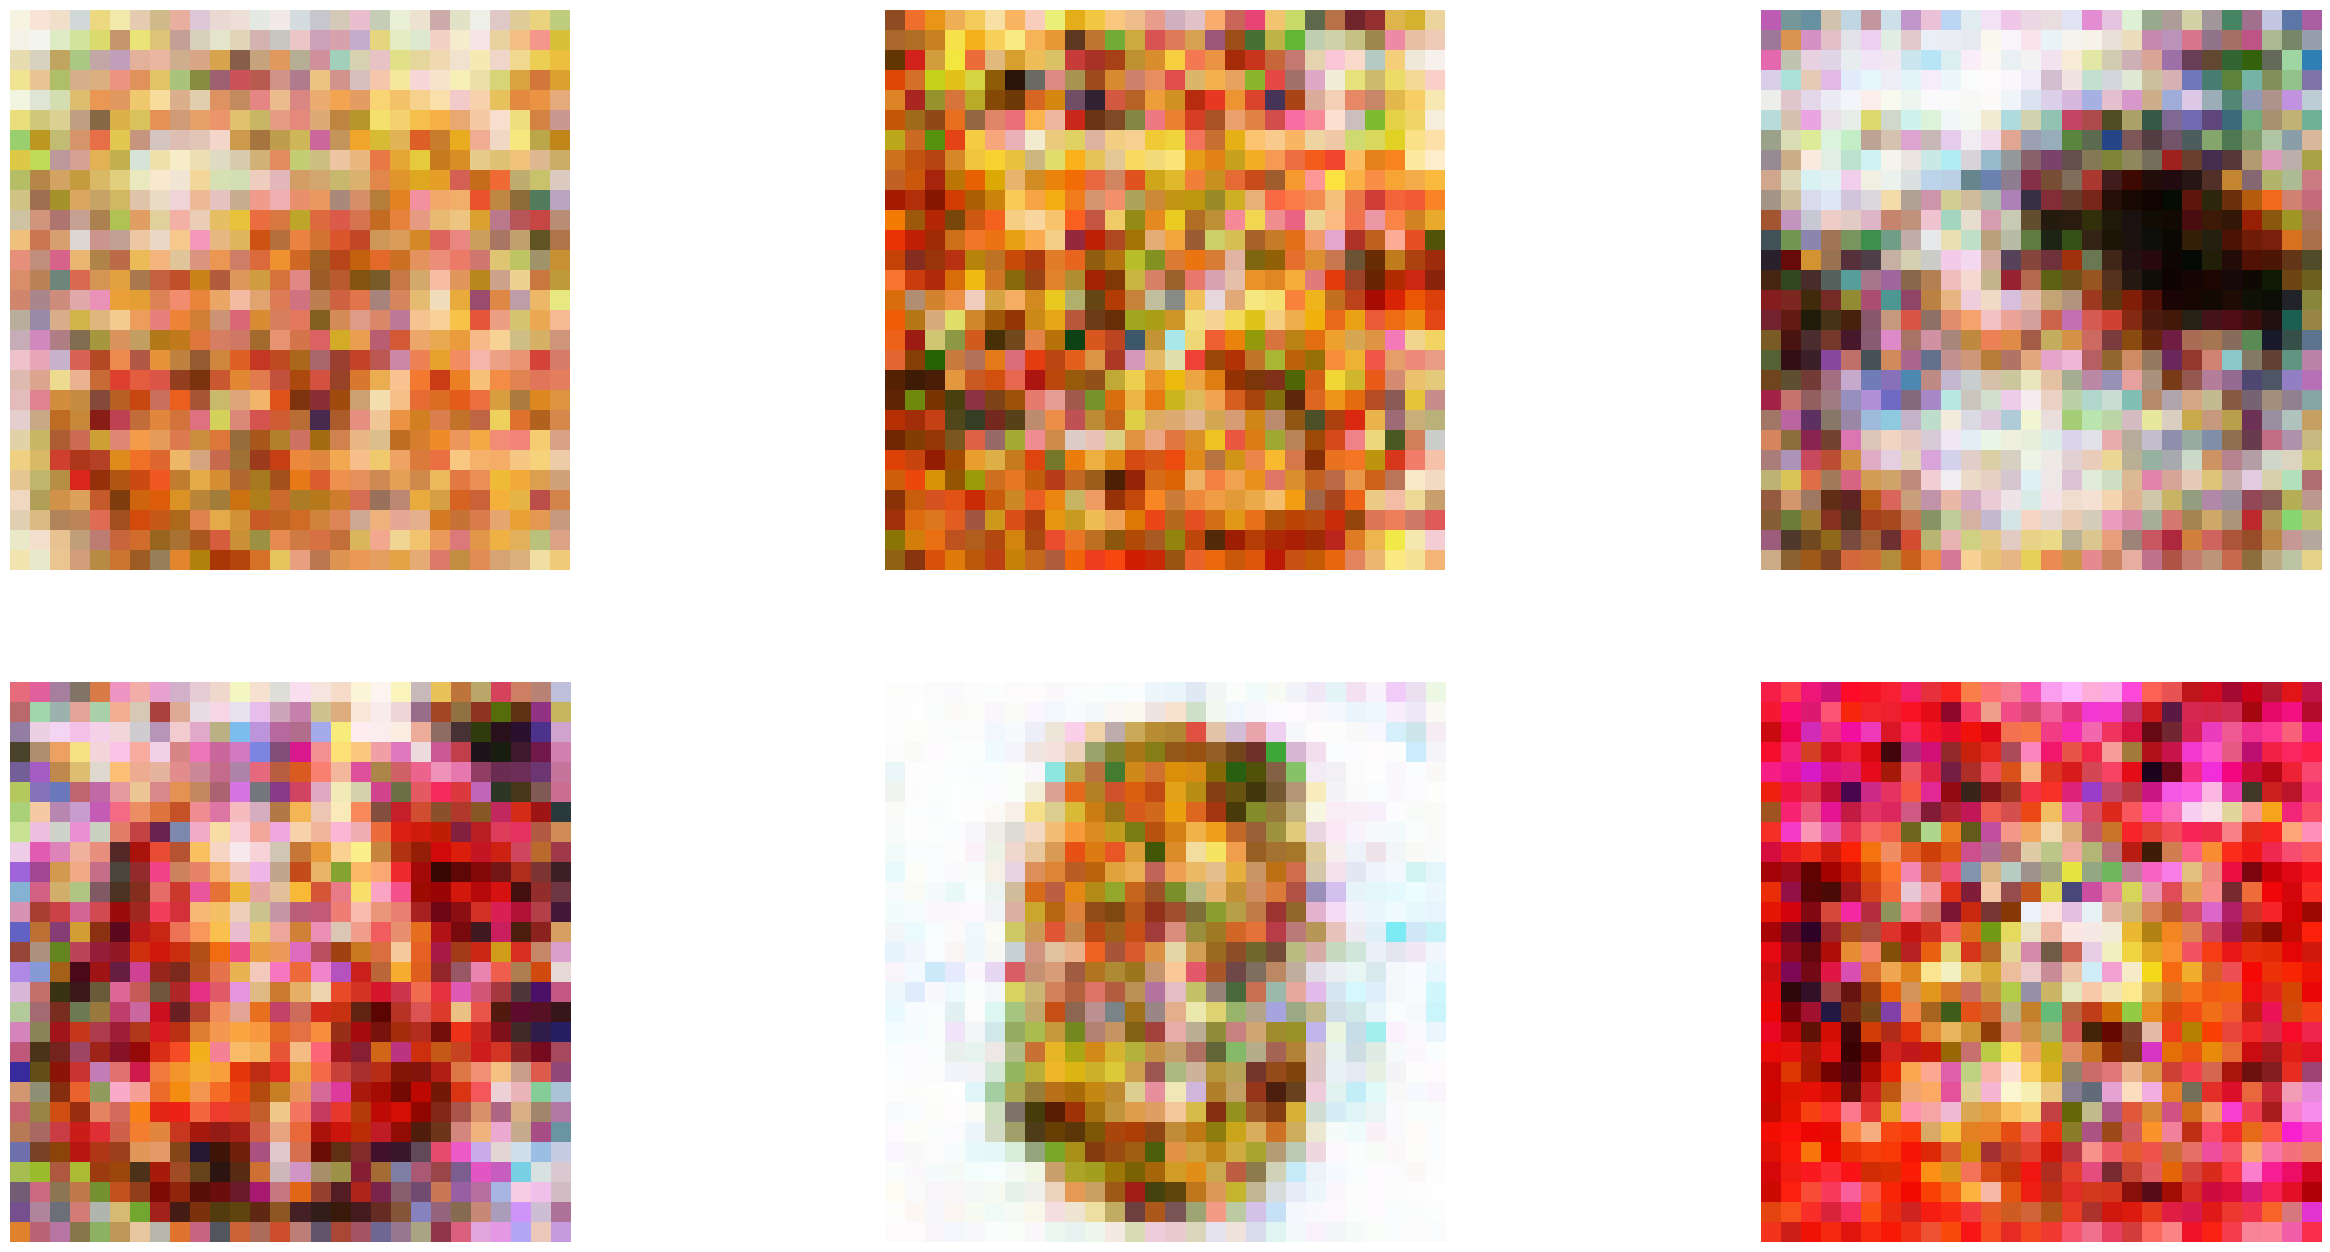

In [70]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [71]:
label = "Pizza"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


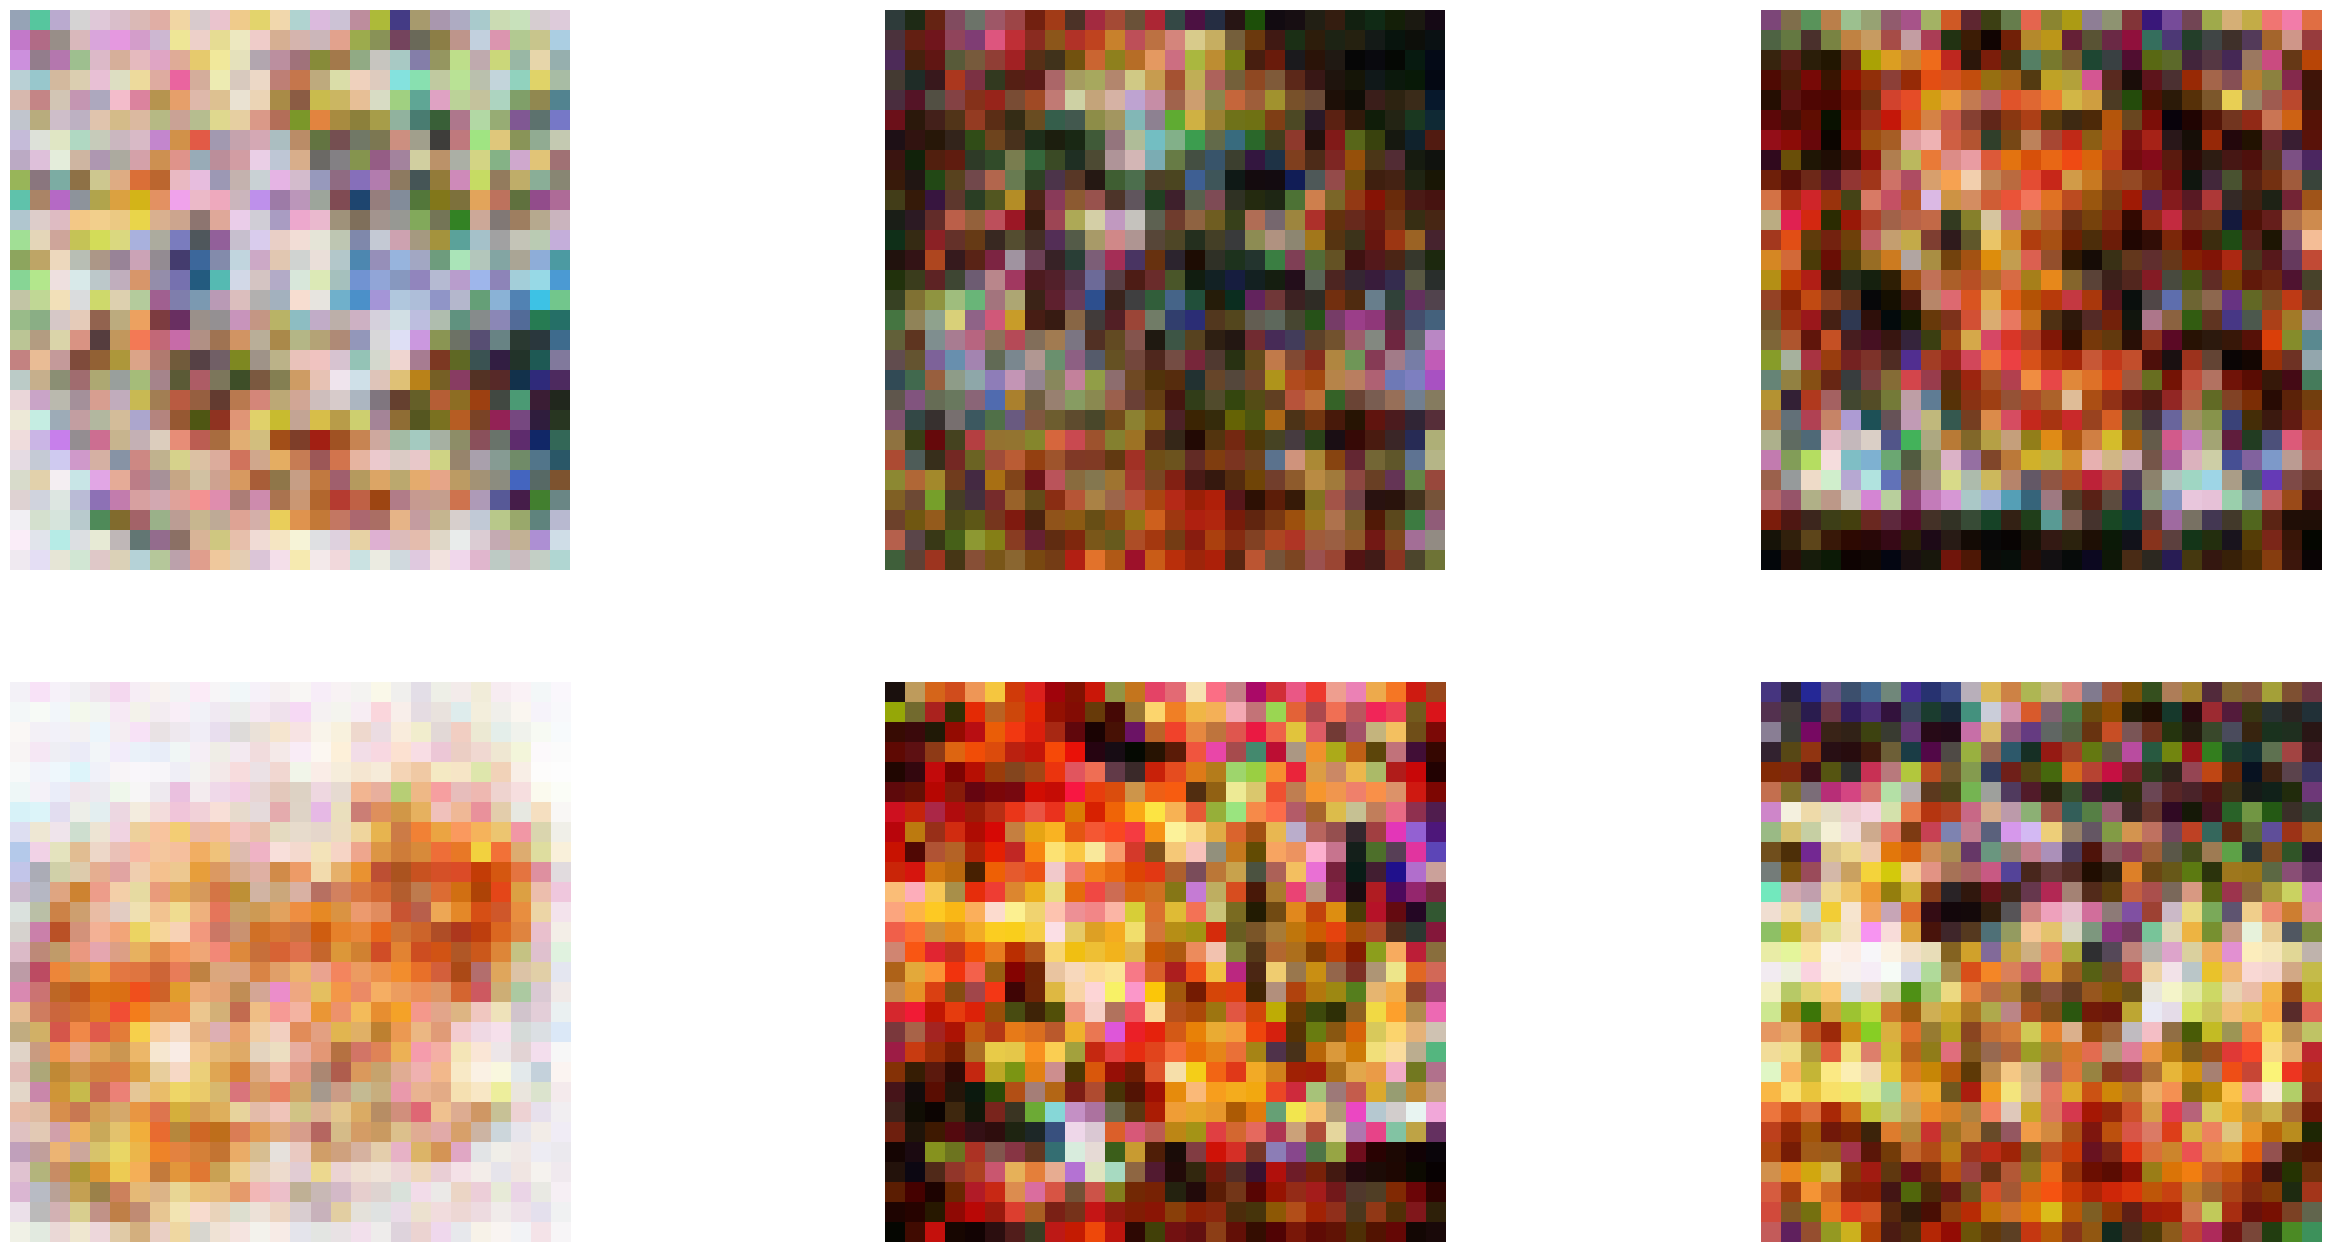

In [72]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [73]:
label = "Sandwich"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


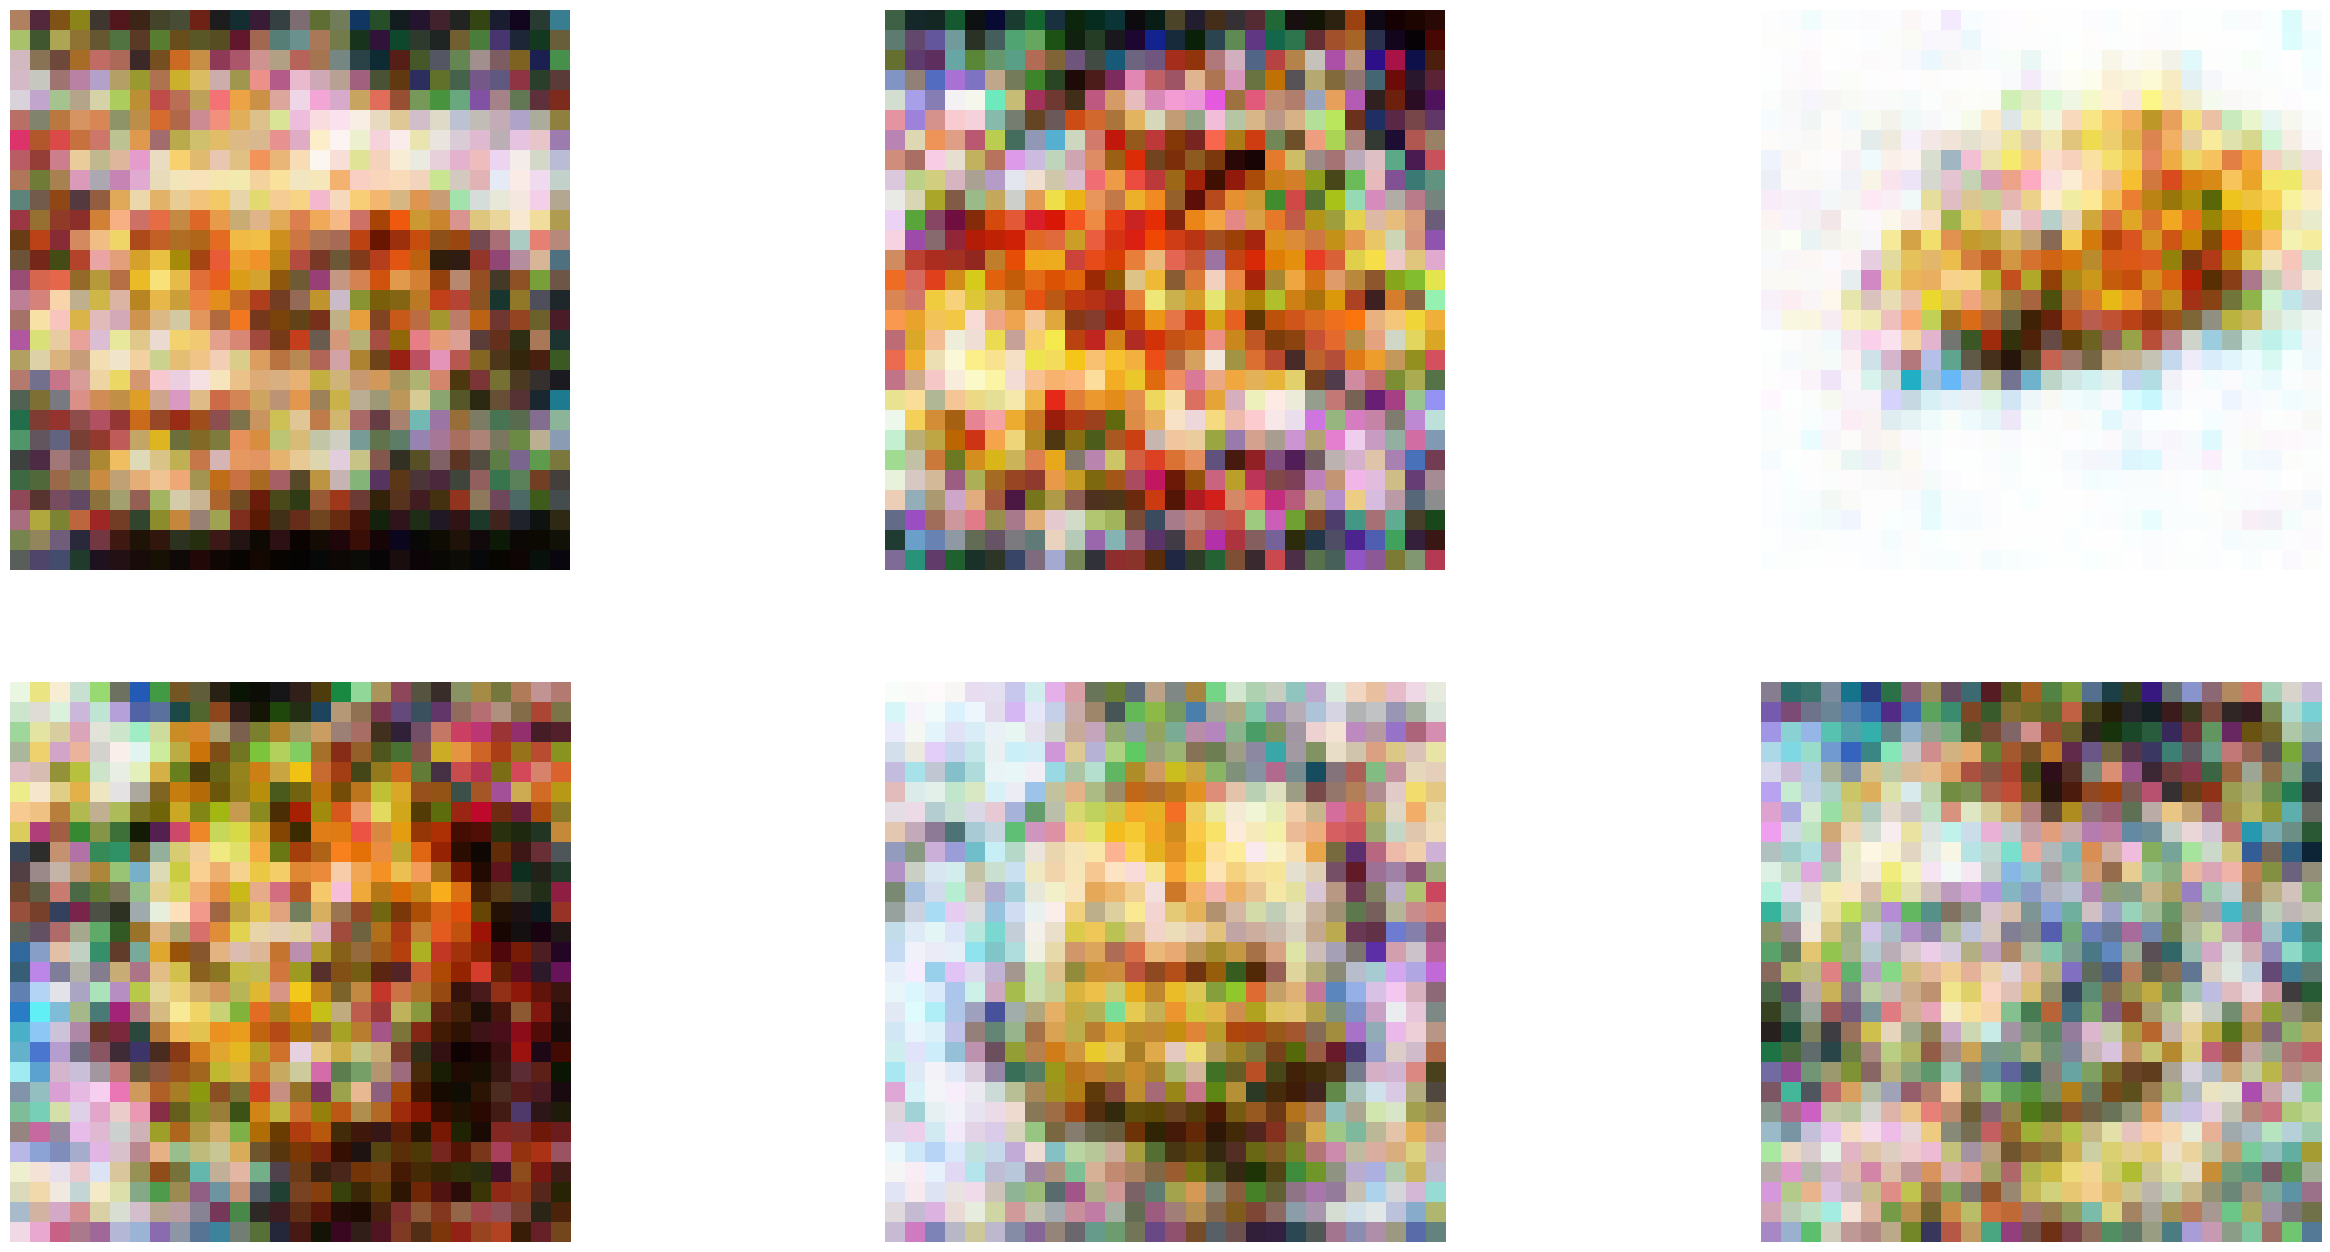

In [74]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [75]:
label = "Taco"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


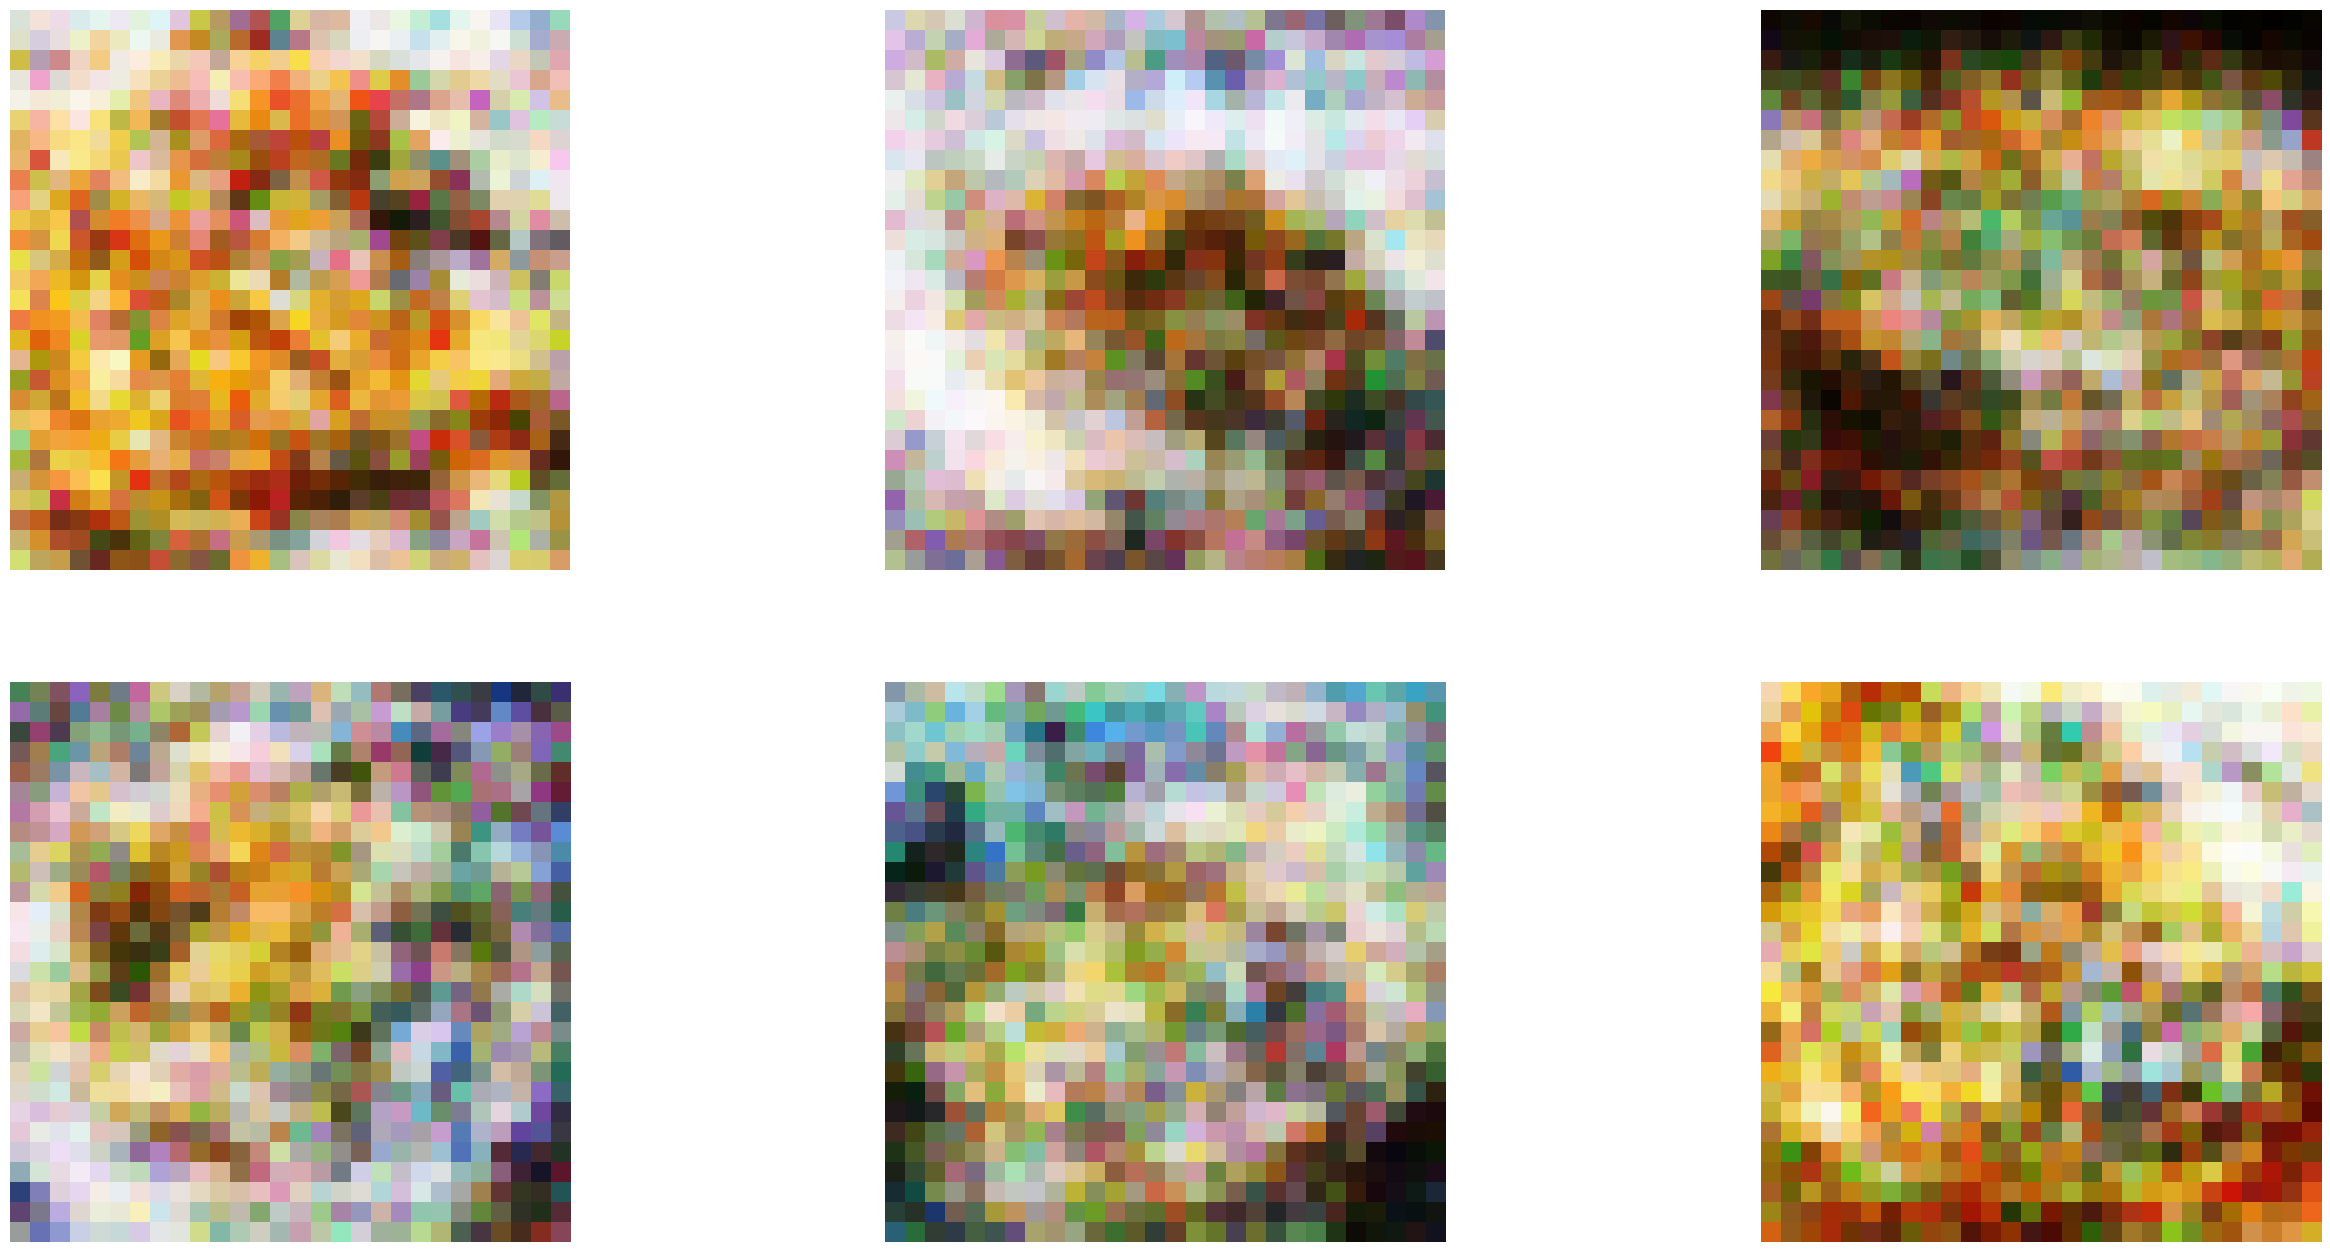

In [76]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()

In [77]:
label = "Taquito"

label_dex = label_index[label]
        
label_tensor = torch.zeros((10))
label_tensor[label_dex] = 1.0

        
label_tensor = label_tensor.unsqueeze(0)

Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])
Output shape: torch.Size([1, 2352])


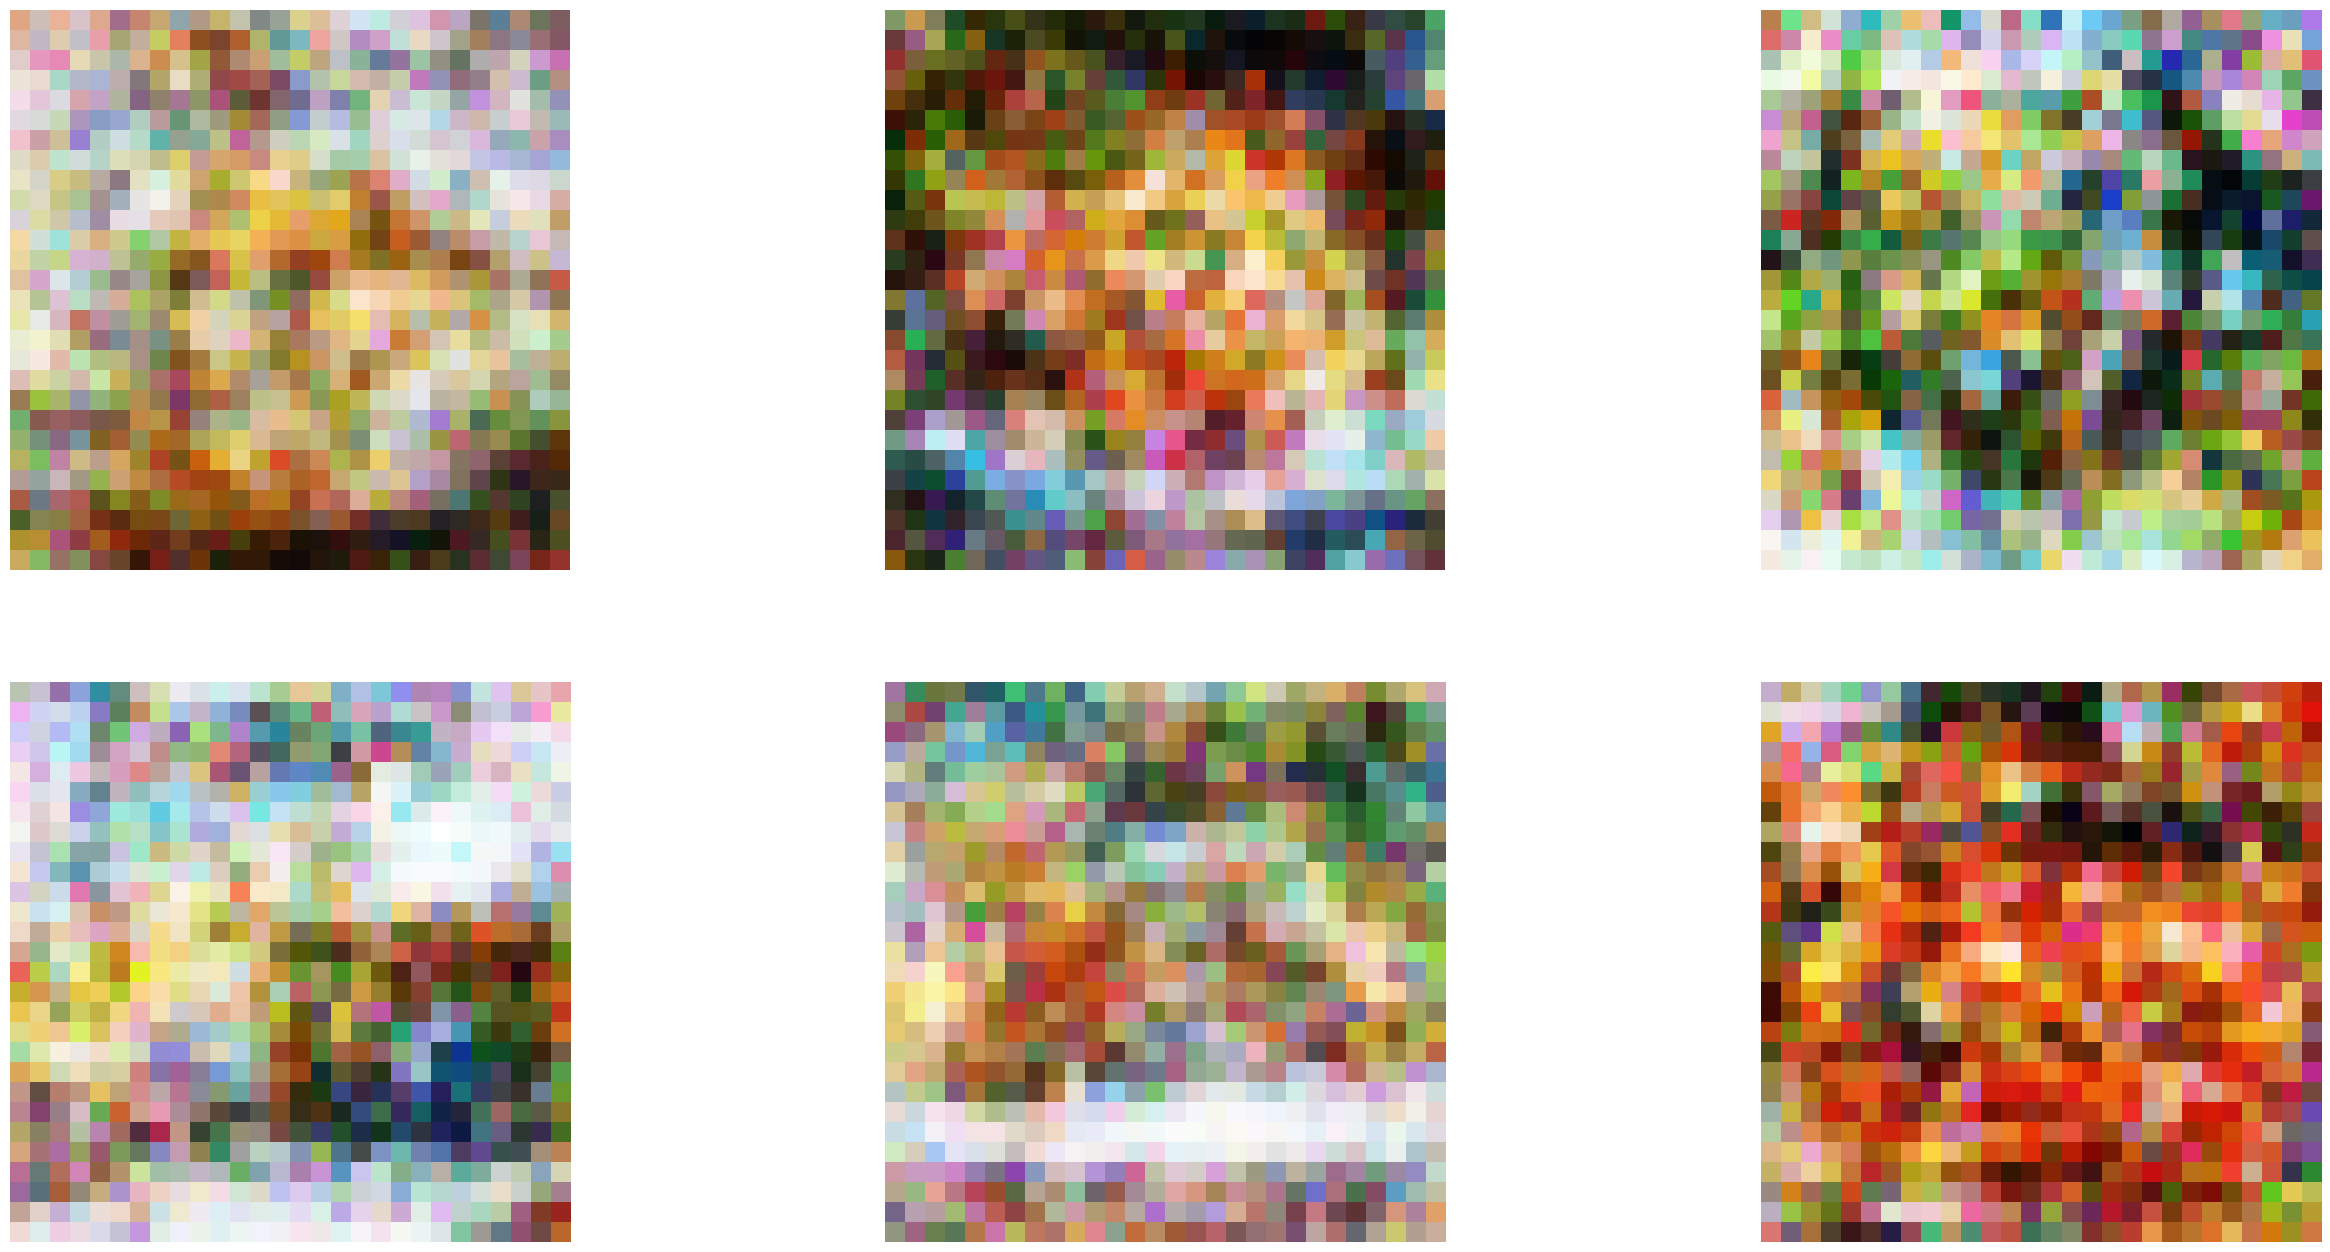

In [78]:
D_model.eval()
G_model.eval()

f, axarr = plt.subplots(2,3, figsize=(32,16))

for i in range(2):
    for j in range(3):
        # Generate a random input vector and get model output
        output = G_model.forward(random_G_vector_input().unsqueeze(0), label_tensor)

        # Print the output shape for debugging
        print("Output shape:", output.shape)

        img = output.detach().numpy().reshape(3, 28, 28).transpose(1, 2, 0)  # For RGB
        img = (img + 1) / 2

        # Display the image
        axarr[i, j].imshow(img, interpolation='none')
        axarr[i, j].axis('off')

plt.show()